# Análise de Classificação - Previsão e Detecção de Risco de Crédito

Este projeto tem como objetivo apenas para fins educacionais, com intuito de praticar todo o conhecimento adquirido no curso de Machine Learning da formação Cientista de Dados, ministrado pela Data Science Academy. Este projeto foi fornecido como exemplo em linguagem R durante o curso, e fiz a conversão para linguagem Python para praticar. Neste exemplo, foi ensinado apenas a regressão logística, porém, nesse jupyter notebook conterá todo o conhecimento adquirido por mim durante o curso.

## Definindo o Problema de Negócio

O objetivo deste projeto é desenvolver um sistema de Previsão e Detecção de Risco de Crédito que possa auxiliar instituições financeiras na avaliação de pedidos de empréstimos baseado nas informações contidas no dataset. Baseado nessas informações, o modelo irá avaliar se aprovará o emprestimo (sim - 1) ou não aprovará o emprestimo (não - 0)

O dataset foi disponibilizado pela Data Sciende Academy.

## Carregando pacotes e Dataset

In [106]:
# Importando pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline 

In [2]:
# Carregando dataset
df = pd.read_csv('dados/credit_dataset_final.csv')
df.head()

,credit.rating,account.balance,credit.duration.months,previous.credit.payment.status,credit.purpose,credit.amount,savings,employment.duration,installment.rate,marital.status,...,residence.duration,current.assets,age,other.credits,apartment.type,bank.credits,occupation,dependents,telephone,foreign.worker
0,1,1,18,3,2,1049,1,1,4,1,...,4,2,21,2,1,1,3,1,1,1
1,1,1,9,3,4,2799,1,2,2,3,...,2,1,36,2,1,2,3,2,1,1
2,1,2,12,2,4,841,2,3,2,1,...,4,1,23,2,1,1,2,1,1,1
3,1,1,12,3,4,2122,1,2,3,3,...,2,1,39,2,1,2,2,2,1,2
4,1,1,12,3,4,2171,1,2,4,3,...,4,2,38,1,2,2,2,1,1,2


In [3]:
# Coletando X e y
X = df.iloc[:, 1:]
y = df['credit.rating']

# Gerando número de observações e variáveis
observasoes = len(df)
variaveis = df.columns[1:]

## Análise Exploratória

Nesa etapa iremos plotar alguns gráficos para entender melhor os dados, realizar algumas análises e observar como estão distribuidos.

**A variável target está banaceada?**

Não, Será necessário aplicar alguma técnica de balanceamento na variável target.

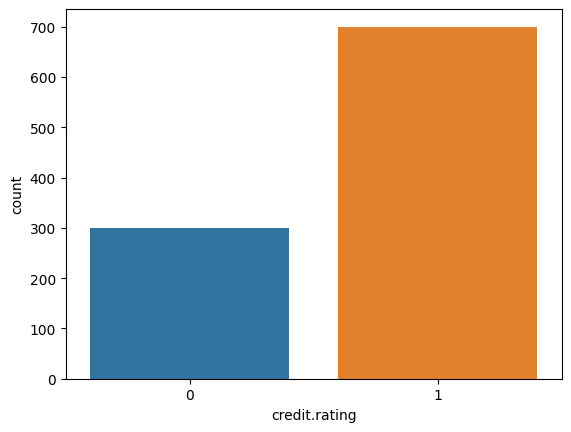

In [4]:
sns.countplot(df, x= 'credit.rating')
plt.show()

## Balanceamento da Variável Target

In [5]:
# Gerando dados sintéticos da classe minoritária
smote = SMOTE(random_state= 42)
X, y = smote.fit_resample(X, y)

# Shape
print('Shape do dataset %s' % Counter(y))

Shape do dataset Counter({1: 700, 0: 700})


## Feature Scaling

Usaremos a técnica de **padronização** para deixar os dados numéricos contínuos na mesma escala.

In [6]:
# Selecionando as variáveis numéricas contínuas
var_num = ['credit.duration.months', 'age', 'credit.amount']

# Aplicando padronização
scaler = StandardScaler()
# X[var_num] = scaler.fit_transform(X[var_num])
X = scaler.fit_transform(X)

## Seleção de Variáveis

Nesta etapa vamos criar um gráfico para visualizarmos se há forte correlação entre as variáveis, e logo em seguida, avaliaremos se há variáveis com multicolinearidade utilizando autovalores e autovetores. Também utilizaremos o RandomForest para verificar quais variáveis são as mais importantes para o modelo.

### Análise de Correlação

In [7]:
# Criando matriz de correlação
matriz_corr = X.corr()

# Definindo tamanho do gráfico
plt.figure(figsize= (15, 15))

# Plot
sns.heatmap(matriz_corr, annot= True)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [8]:
# Gerando autovalores e autovetores
corr = np.corrcoef(X, rowvar = 0)
autovalores, autovetores = np.linalg.eig(corr)

In [9]:
print(autovalores)

[2.7490527  2.15060181 1.38957148 0.25832588 1.30851882 1.19700823
 1.14010534 1.11198316 0.47259932 0.51136472 0.52796821 0.60028429
 0.98631114 0.95170869 0.66728539 0.69214294 0.86405228 0.77405565
 0.8285285  0.81853144]


In [10]:
print(autovetores[:,3])

[ 0.00158099  0.56302539 -0.06802126 -0.01731543 -0.7283358   0.02217316
 -0.04002728 -0.31556196  0.03887058  0.01388291 -0.03078003  0.07126339
  0.09510484 -0.00093242 -0.02852861  0.06199382  0.07300098 -0.0163896
  0.12804425  0.05001419]


In [11]:
print(variaveis[1], variaveis[4], variaveis[7])

credit.duration.months credit.amount installment.rate


As variáveis **credit.duration.months, credit.amount e installment.rate** são responsáveis pela multicoliniaridade no dataset.

### Random Forest

In [14]:
# Criando o modelo
selec_feature = RandomForestClassifier(n_estimators= 100)

# Treinando o modelo
selec_feature.fit(X, y)

# Extraindo a importância
importances = selec_feature.feature_importances_
indices = np.argsort(importances)

# Buscando os nomes das colunas
labels = X.columns

# Obtém os índices
ind = []

for i in indices:
    ind.append(labels[i])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

NameError: name 'ind' is not defined

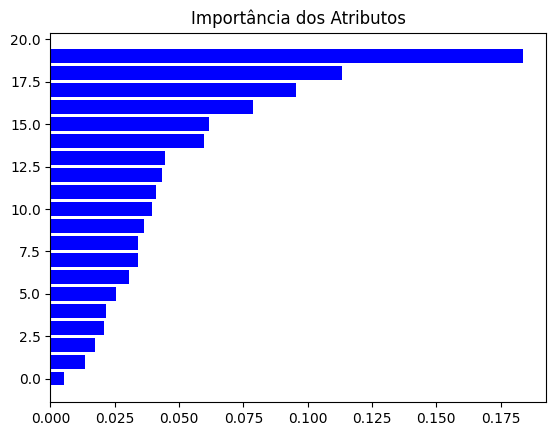

In [15]:
# Plot da Importância dos Atributos
plt.figure(1)
plt.title('Importância dos Atributos')
plt.barh(range(len(indices)), importances[indices], color= 'b', align= 'center')
plt.yticks(range(len(indices)), ind)
plt.xlabel('Importância Relativa')
plt.show()

## Treinamento do Modelo

* 1º Dataset: conterá todas as variáveis.
* 2º Dataset: Será removido as variáveis foreign.worker, dependents, guarantor, telephone, occupation e installment.rate.

In [16]:
# 1º Dataset
# X = X.copy()

# 2º Dataset
X = X.drop(columns= ['foreign.worker', 'dependents', 'guarantor', 'telephone', 'occupation', 'installment.rate', 'bank.credits', 'apartment.type', 'other.credits'])

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

### Regressão Logística

In [17]:
# Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# Treinando o modelo
modelo_lr_v1 = LogisticRegression()
modelo_lr_v1.fit(X_train, y_train)

# Previsões
y_pred = modelo_lr_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.8119047619047619
Matriz de Confusão:
[[175  35]
 [ 44 166]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       210
           1       0.83      0.79      0.81       210

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



## K-Nearest Neighbor

In [18]:
# Divisão em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [19]:
# Divisão dos dados de treino em dados de treino e dados de validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [20]:
# Número de registros em cada dataset
print("Registros de Treino: {}".format(len(X_train)))
print("Registros de Validação: {}".format(len(X_val)))
print("Registros de Teste: {}".format(len(X_test)))

Registros de Treino: 1008
Registros de Validação: 112
Registros de Teste: 280


In [21]:
# Range de valores de k
kVals = range(1, 30, 2)

# Lista para receber o valor de acurácia
acuracias = []

# Loop em todos os valores de k para testar cada um deles
for k in kVals:
    
    # Treinando o modelo KNN com cada valor de k
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(X_train, y_train)
          
    # Avaliando o modelo e atualizando a lista de acurácias
    score = modeloKNN.score(X_val, y_val)
    print("Com valor de k = %d, a acurácia é = %.2f%%" % (k, score * 100))
    acuracias.append(score)

Com valor de k = 1, a acurácia é = 81.25%
Com valor de k = 3, a acurácia é = 80.36%
Com valor de k = 5, a acurácia é = 75.89%
Com valor de k = 7, a acurácia é = 74.11%
Com valor de k = 9, a acurácia é = 76.79%
Com valor de k = 11, a acurácia é = 77.68%
Com valor de k = 13, a acurácia é = 75.00%
Com valor de k = 15, a acurácia é = 76.79%
Com valor de k = 17, a acurácia é = 75.00%
Com valor de k = 19, a acurácia é = 74.11%
Com valor de k = 21, a acurácia é = 73.21%
Com valor de k = 23, a acurácia é = 74.11%
Com valor de k = 25, a acurácia é = 76.79%
Com valor de k = 27, a acurácia é = 78.57%
Com valor de k = 29, a acurácia é = 76.79%


In [22]:
# Obtendo o valor de k que apresentou a maior acurácia
i = np.argmax(acuracias)
print("O valor de k = %d alcançou a mais alta acurácia de %.2f%% nos dados de validação!" % (kVals[i], 
                                                                                             acuracias[i] * 100))

O valor de k = 1 alcançou a mais alta acurácia de 81.25% nos dados de validação!


**Primeira Versão**

In [23]:
# Criando a versão final do modelo com o maior valor de k
modelo_knn_v1 = KNeighborsClassifier(n_neighbors = kVals[i])

# Treinamento do modelo
modelo_knn_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_knn_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7821428571428571
Matriz de Confusão:
[[113  26]
 [ 35 106]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       139
           1       0.80      0.75      0.78       141

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.78       280
weighted avg       0.78      0.78      0.78       280



**Segunda Versão**

In [24]:
# Criando a versão final do modelo com o maior valor de k
modelo_knn_v2 = KNeighborsClassifier(n_neighbors = kVals[i])

param = {'weights': ['uniform', 'distance'], 
         'p': [1, 2, 3, 4, 5], 
         'metric': ['euclidean', 'manhattam', 'minkowski']}

grid_search = GridSearchCV(modelo_knn_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_knn_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_knn_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'metric': 'minkowski', 'p': 1, 'weights': 'uniform'}
Acurácia: 0.8428571428571429
Matriz de Confusão:
[[124  15]
 [ 29 112]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       139
           1       0.88      0.79      0.84       141

    accuracy                           0.84       280
   macro avg       0.85      0.84      0.84       280
weighted avg       0.85      0.84      0.84       280



### Naive Bayes BernoulliNB

In [25]:
# Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# Treinando o modelo
modelo_nb_v1 = BernoulliNB()
modelo_nb_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_nb_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.780952380952381
Matriz de Confusão:
[[161  46]
 [ 46 167]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       207
           1       0.78      0.78      0.78       213

    accuracy                           0.78       420
   macro avg       0.78      0.78      0.78       420
weighted avg       0.78      0.78      0.78       420



### Decision Tree Classifier

In [26]:
# Instânciando o modelo
modelo_decisionTree_v1 = DecisionTreeClassifier(max_depth = None, 
                                                max_features = None, 
                                                criterion = 'gini', 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2)

# Treinando o modelo
modelo_decisionTree_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_decisionTree_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7452380952380953
Matriz de Confusão:
[[160  47]
 [ 60 153]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       207
           1       0.77      0.72      0.74       213

    accuracy                           0.75       420
   macro avg       0.75      0.75      0.75       420
weighted avg       0.75      0.75      0.75       420



### Random Forest Classifier

**Primeira Versão**

In [54]:
# Instanciando o modelo
modelo_randomForest_v1 = RandomForestClassifier(n_estimators= 1000, 
                                                max_depth= 5, 
                                                max_features= 3, 
                                                criterion= 'gini', 
                                                min_samples_leaf= 1, 
                                                min_samples_split= 2, 
                        )

# Treinando o modelo
modelo_randomForest_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_randomForest_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.8357142857142857
Matriz de Confusão:
[[184  23]
 [ 46 167]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       207
           1       0.88      0.78      0.83       213

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



**Segunda Versão**

In [26]:
# Instanciando o modelo
modelo_randomForest_v2 = RandomForestClassifier()

# Definindo os parâmetros
param = {'max_depth': [None, 5, 10, 25], 
         'n_estimators': [300, 500, 1000],
         'max_features': ['sqrt', 'log2', None], 
         'min_samples_leaf': [1, 3, 5], 
         'min_samples_split': [2, 3, 5],
         'bootstrap': [True, False], 
         'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(modelo_randomForest_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_randomForest_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_randomForest_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Acurácia: 0.8071428571428572
Matriz de Confusão:
[[180  37]
 [ 44 159]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       217
           1       0.81      0.78      0.80       203

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



**Terceira Versão**

In [113]:
# Instanciando o modelo
modelo_randomForest_v3 = RandomForestClassifier()

# Definindo os parâmetros
param = {'max_depth': Integer(2, 16), 
         'n_estimators': Integer(300, 3000),
         'max_features': Categorical(['sqrt', 'log2', None]), 
         'min_samples_leaf': Integer(2, 25), 
         'min_samples_split': Integer(2, 50),
         'bootstrap': Categorical([True, False]), 
         'criterion': Categorical(['gini', 'entropy', 'log_loss']), 
         'class_weight': Categorical(['balanced', 'balanced_subsample', None])}

bayses_search = BayesSearchCV(modelo_randomForest_v3, param, n_iter= 50, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
bayses_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = bayses_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_randomForest_v3 = bayses_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_randomForest_v3.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: OrderedDict([('bootstrap', True), ('class_weight', 'balanced'), ('criterion', 'gini'), ('max_depth', 14), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 1196)])
Acurácia: 0.8357142857142857
Matriz de Confusão:
[[180  27]
 [ 42 171]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       207
           1       0.86      0.80      0.83       213

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



### Bagging Classifier

**Primeira Versão**

In [55]:
# Instanciando o modelo
modelo_bagging_v1 = BaggingClassifier(KNeighborsClassifier(), n_estimators= 1000, max_samples = 0.5, max_features = 0.5)

# Treinando o modelo
modelo_bagging_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_bagging_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.8214285714285714
Matriz de Confusão:
[[177  30]
 [ 45 168]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       207
           1       0.85      0.79      0.82       213

    accuracy                           0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420



**Segunda Versão**

In [28]:
# Instanciando o modelo
modelo_bagging_v2 = BaggingClassifier(KNeighborsClassifier())

# Parâmetros
param = {'n_estimators': [300, 500, 1000, 3000], 
       'max_samples': [0.3, 0.5, 0.8], 
       'max_features': [0.3, 0.5, 0.8], 
       'bootstrap': [True, False], 
       }

grid_search = GridSearchCV(modelo_bagging_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_bagging_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_bagging_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'bootstrap': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 1000}
Acurácia: 0.8047619047619048
Matriz de Confusão:
[[183  34]
 [ 48 155]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       217
           1       0.82      0.76      0.79       203

    accuracy                           0.80       420
   macro avg       0.81      0.80      0.80       420
weighted avg       0.81      0.80      0.80       420



**Terceira Versão**

In [29]:
# Instanciando o modelo
modelo_bagging_v3 = BaggingClassifier(KNeighborsClassifier())

# Parâmetros
param = {
    'n_estimators': [300, 500, 1000, 3000],
    'max_samples': [0.3, 0.5, 0.7],
    'max_features': [0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'base_estimator__n_neighbors': [3, 5, 7],
    'base_estimator__weights': ['uniform', 'distance'],
    'base_estimator__p': [1, 2],
    'base_estimator__metric': ['euclidean', 'manhattan', 'minkowski'],
}

grid_search = GridSearchCV(modelo_bagging_v3, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_bagging_v3 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_bagging_v3.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'base_estimator__metric': 'manhattan', 'base_estimator__n_neighbors': 7, 'base_estimator__p': 1, 'base_estimator__weights': 'distance', 'bootstrap': False, 'max_features': 0.3, 'max_samples': 0.7, 'n_estimators': 300}
Acurácia: 0.8095238095238095
Matriz de Confusão:
[[171  46]
 [ 34 169]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       217
           1       0.79      0.83      0.81       203

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



**Quarta Versão**

In [122]:
# Instanciando o modelo
modelo_bagging_v4 = BaggingClassifier(KNeighborsClassifier())

# Parâmetros
param = {
    'n_estimators': Integer(1000, 5000),
    'max_samples': Real(0.2, 0.8),
    'max_features': Real(0.2, 0.8),
    'bootstrap': Categorical([True, False]),
    'base_estimator__n_neighbors': Integer(1, 30),
    'base_estimator__weights': Categorical(['uniform', 'distance']),
    'base_estimator__p': Integer(1, 25),
    'base_estimator__metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
}

bayses_search = BayesSearchCV(modelo_bagging_v4, param, n_iter=50, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
bayses_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = bayses_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_bagging_v4 = bayses_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_bagging_v4.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: OrderedDict([('base_estimator__metric', 'minkowski'), ('base_estimator__n_neighbors', 1), ('base_estimator__p', 1), ('base_estimator__weights', 'uniform'), ('bootstrap', True), ('max_features', 0.2), ('max_samples', 0.8), ('n_estimators', 1000)])
Acurácia: 0.8452380952380952
Matriz de Confusão:
[[177  30]
 [ 35 178]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       207
           1       0.86      0.84      0.85       213

    accuracy                           0.85       420
   macro avg       0.85      0.85      0.85       420
weighted avg       0.85      0.85      0.85       420



### ExtraTrees Classifier

In [56]:
# Instanciando o modelo
modelo_extraTree_v1 = ExtraTreesClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 2)

# Treinando o modelo
modelo_extraTree_v1.fit(X_train, y_train)

# Previsões com dados de teste
y_pred = modelo_extraTree_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acuracia: {accuracy}')
print(f'Matris de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acuracia: 0.8166666666666667
Matris de Confusão:
[[178  29]
 [ 48 165]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       207
           1       0.85      0.77      0.81       213

    accuracy                           0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420



### AdaBoost Classifier

In [57]:
# Criando o modelo
modelo_adaBoost_v1 = AdaBoostClassifier(base_estimator= modelo_decisionTree_v1, 
                                        learning_rate= 0.1, 
                                        n_estimators= 100, 
                                        algorithm= 'SAMME')

# Treinando o modelo
modelo_adaBoost_v1.fit(X_train, y_train)

# Previsões com dados de teste
y_pred = modelo_adaBoost_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matris de confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7357142857142858
Matris de confusão:
[[160  47]
 [ 64 149]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       207
           1       0.76      0.70      0.73       213

    accuracy                           0.74       420
   macro avg       0.74      0.74      0.74       420
weighted avg       0.74      0.74      0.74       420



### Gradient Boosting Classifier

**Primeira Versão**

In [103]:
# Criando o modelo 
modelo_gradientBoosting_v1 = GradientBoostingClassifier(n_estimators= 3000, 
                                                        max_depth= 7, 
                                                        learning_rate= 000.1, 
                                                        max_features= 5, 
                                                        min_samples_leaf= 3, 
                                                        min_samples_split= 3, 
                                                        subsample= 0.5)

# Treinando o modelo
modelo_gradientBoosting_v1.fit(X_train, y_train)

# Previsão com dados de teste
y_pred = modelo_gradientBoosting_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão: \n{conf_matrix}')
print(f'Relatório de Classificação: \n{classification_rep}')

Acurácia: 0.8404761904761905
Matriz de Confusão: 
[[179  28]
 [ 39 174]]
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       207
           1       0.86      0.82      0.84       213

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



**Segunda Versão**

In [ ]:
# Criando o modelo 
modelo_gradientBoosting_v2 = GradientBoostingClassifier()

# Parâmetros
param = {'learning_rate': [0.1, 0.01, 0.001], 
         'max_depth': [None, 3, 10, 50, 70], 
         'max_features': [1, 3, 5],
         'min_samples_leaf': [3, 4, 5], 
         'min_samples_split': [2, 5, 10],
         'subsample': [0.3, 0.5, 0.7], 
         'n_estimators': [400, 700, 1000, 2000, 3000]
        }

# Aplicando o grid search
grid_search = GridSearchCV(modelo_gradientBoosting_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_gradientBoosting_v2 = grid_search.best_estimator_

# Previsão com dados de teste
y_pred = modelo_gradientBoosting_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão: \n{conf_matrix}')
print(f'Relatório de Classificação: \n{classification_rep}')